#### <center>Домашнее задание SPARK</center>

<div class="alert alert-block alert-info">    
Для произвольно выбранного датасета провести обработку данных и построить предсказательную модель с использованием функционала <b>pySpark</b>.
</div>

In [2]:
#Без этого костыля у меня не работал
import os
import sys

os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

In [3]:
import numpy as np
import pandas as pd
import gc

import urllib.request

from pyspark.sql import SparkSession

from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("Pyspark") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "8g") \
  .config("spark.driver.memory", "8g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","8g")\
  .getOrCreate()



Получить `Spark DataFrame` через `SparkSession` можно только из локального файла, для удаленного чтения файла нужны библиотеки `Python`.

In [5]:
df = spark.read.csv('winequality-red.csv', sep=';', 
                    inferSchema=True, header=True)

In [6]:
df.show(3)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
+-------------+----------------+-----------+--------------+---------+-------------------+-----------

In [7]:
# Тип переменных
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [8]:
# Еще один "замечательный" вывод первых трех строк
df.head(3)

[Row(fixed acidity=7.4, volatile acidity=0.7, citric acid=0.0, residual sugar=1.9, chlorides=0.076, free sulfur dioxide=11.0, total sulfur dioxide=34.0, density=0.9978, pH=3.51, sulphates=0.56, alcohol=9.4, quality=5),
 Row(fixed acidity=7.8, volatile acidity=0.88, citric acid=0.0, residual sugar=2.6, chlorides=0.098, free sulfur dioxide=25.0, total sulfur dioxide=67.0, density=0.9968, pH=3.2, sulphates=0.68, alcohol=9.8, quality=5),
 Row(fixed acidity=7.8, volatile acidity=0.76, citric acid=0.04, residual sugar=2.3, chlorides=0.092, free sulfur dioxide=15.0, total sulfur dioxide=54.0, density=0.997, pH=3.26, sulphates=0.65, alcohol=9.8, quality=5)]

In [9]:
# Количество наблюдений в датасете
print((df.count(),len(df.columns)))

(1599, 12)


In [10]:
df.columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [11]:
# Общая статистика
df.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|              1599|
|   mean

In [12]:
# Для получения читаемой информации можно вывести отдельно
# стстистику по каждой переменной
all_stat = [df.describe([col]).show() for col in df.columns]
all_stat

+-------+------------------+
|summary|     fixed acidity|
+-------+------------------+
|  count|              1599|
|   mean| 8.319637273295838|
| stddev|1.7410963181276948|
|    min|               4.6|
|    max|              15.9|
+-------+------------------+

+-------+-------------------+
|summary|   volatile acidity|
+-------+-------------------+
|  count|               1599|
|   mean| 0.5278205128205131|
| stddev|0.17905970415353525|
|    min|               0.12|
|    max|               1.58|
+-------+-------------------+

+-------+-------------------+
|summary|        citric acid|
+-------+-------------------+
|  count|               1599|
|   mean| 0.2709756097560964|
| stddev|0.19480113740531824|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

+-------+------------------+
|summary|    residual sugar|
+-------+------------------+
|  count|              1599|
|   mean|2.5388055034396517|
| stddev|  1.40992805950728|
|    min|             

[None, None, None, None, None, None, None, None, None, None, None, None]

In [13]:
# Или более привычный вид с методом toPandas
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fixed acidity,1599,8.319637273295838,1.7410963181276948,4.6,15.9
volatile acidity,1599,0.5278205128205131,0.17905970415353525,0.12,1.58
citric acid,1599,0.2709756097560964,0.19480113740531824,0.0,1.0
residual sugar,1599,2.5388055034396517,1.40992805950728,0.9,15.5
chlorides,1599,0.08746654158849257,0.047065302010090085,0.012,0.611
free sulfur dioxide,1599,15.874921826141339,10.46015696980971,1.0,72.0
total sulfur dioxide,1599,46.46779237023139,32.89532447829907,6.0,289.0
density,1599,0.9967466791744831,0.0018873339538427265,0.99007,1.00369
pH,1599,3.311113195747343,0.15438646490354271,2.74,4.01


Метод `dropDuplicates`- вывести или удалить дублирующиеся строки, если они есть.

In [14]:
# Проверяем наличие дублей
df.dropDuplicates().show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          9.9|             0.5|       0.24|           2.3|    0.103|                6.0|                14.0| 0.9978|3.34|     0.52|   10.0|      4|
|          7.7|            0.57|       0.21|           1.5|    0.069|                4.0|                 9.0|0.99458|3.16|     0.54|    9.8|      6|
|          6.4|             0.4|       0.23|           1.6|    0.066|                5.0|                12.0| 0.9958|3.34|     0.56|    9.2|      5|
|         12.0|            0.37|       0.76|           4.2|    0.066|                7.0|           

In [15]:
# Сет без дублей
df_s = df.dropDuplicates()
df_s.count()

1359

In [16]:
gc.collect()

39

In [17]:
df.groupBy('quality').count().show()
# После удаления дубликатов
df_s.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|      7|  199|
|      8|   18|
|      3|   10|
|      5|  681|
|      6|  638|
|      4|   53|
+-------+-----+

+-------+-----+
|quality|count|
+-------+-----+
|      7|  167|
|      8|   17|
|      3|   10|
|      5|  577|
|      6|  535|
|      4|   53|
+-------+-----+



Функция `corr` в `Pandas` может обрабатывать любое количество столбцов, но `corr` для датафрейма `Spark` допускает только два столбца.

In [18]:
# Опять метод toPandas
corr = df_s.toPandas().corr()
# # Примеры вывода значения корреляции
# df_s.select(corr("fixed acidity", "density")).show()

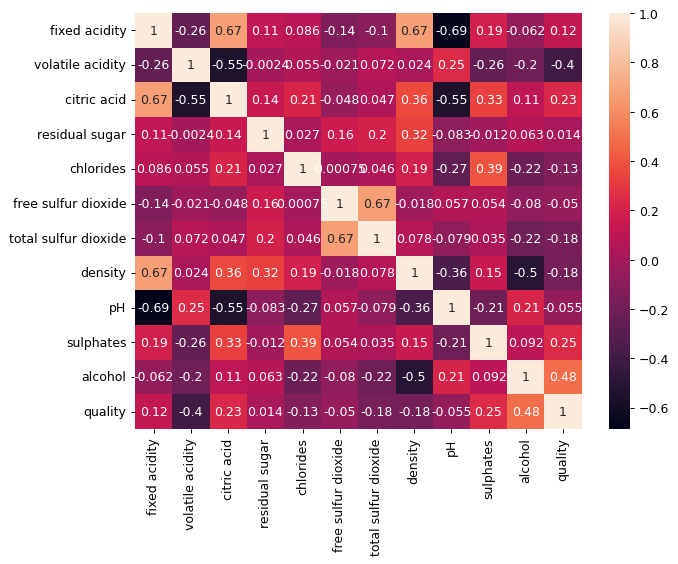

In [19]:


plt.figure(figsize=(8,6), dpi=90)
sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, annot=True)
pass;

In [20]:
# # Проверка наличия пропущенных значений
# na_counts = df_s.select([count(when(isnull(c), c)).alias(c) 
#                       for c in df.columns]).toPandas()
# na_counts

`Spark` напрямую не предоставляет функции визуализации данных, поэтому снова используем сет `Pandas`.

Wall time: 7.4 s


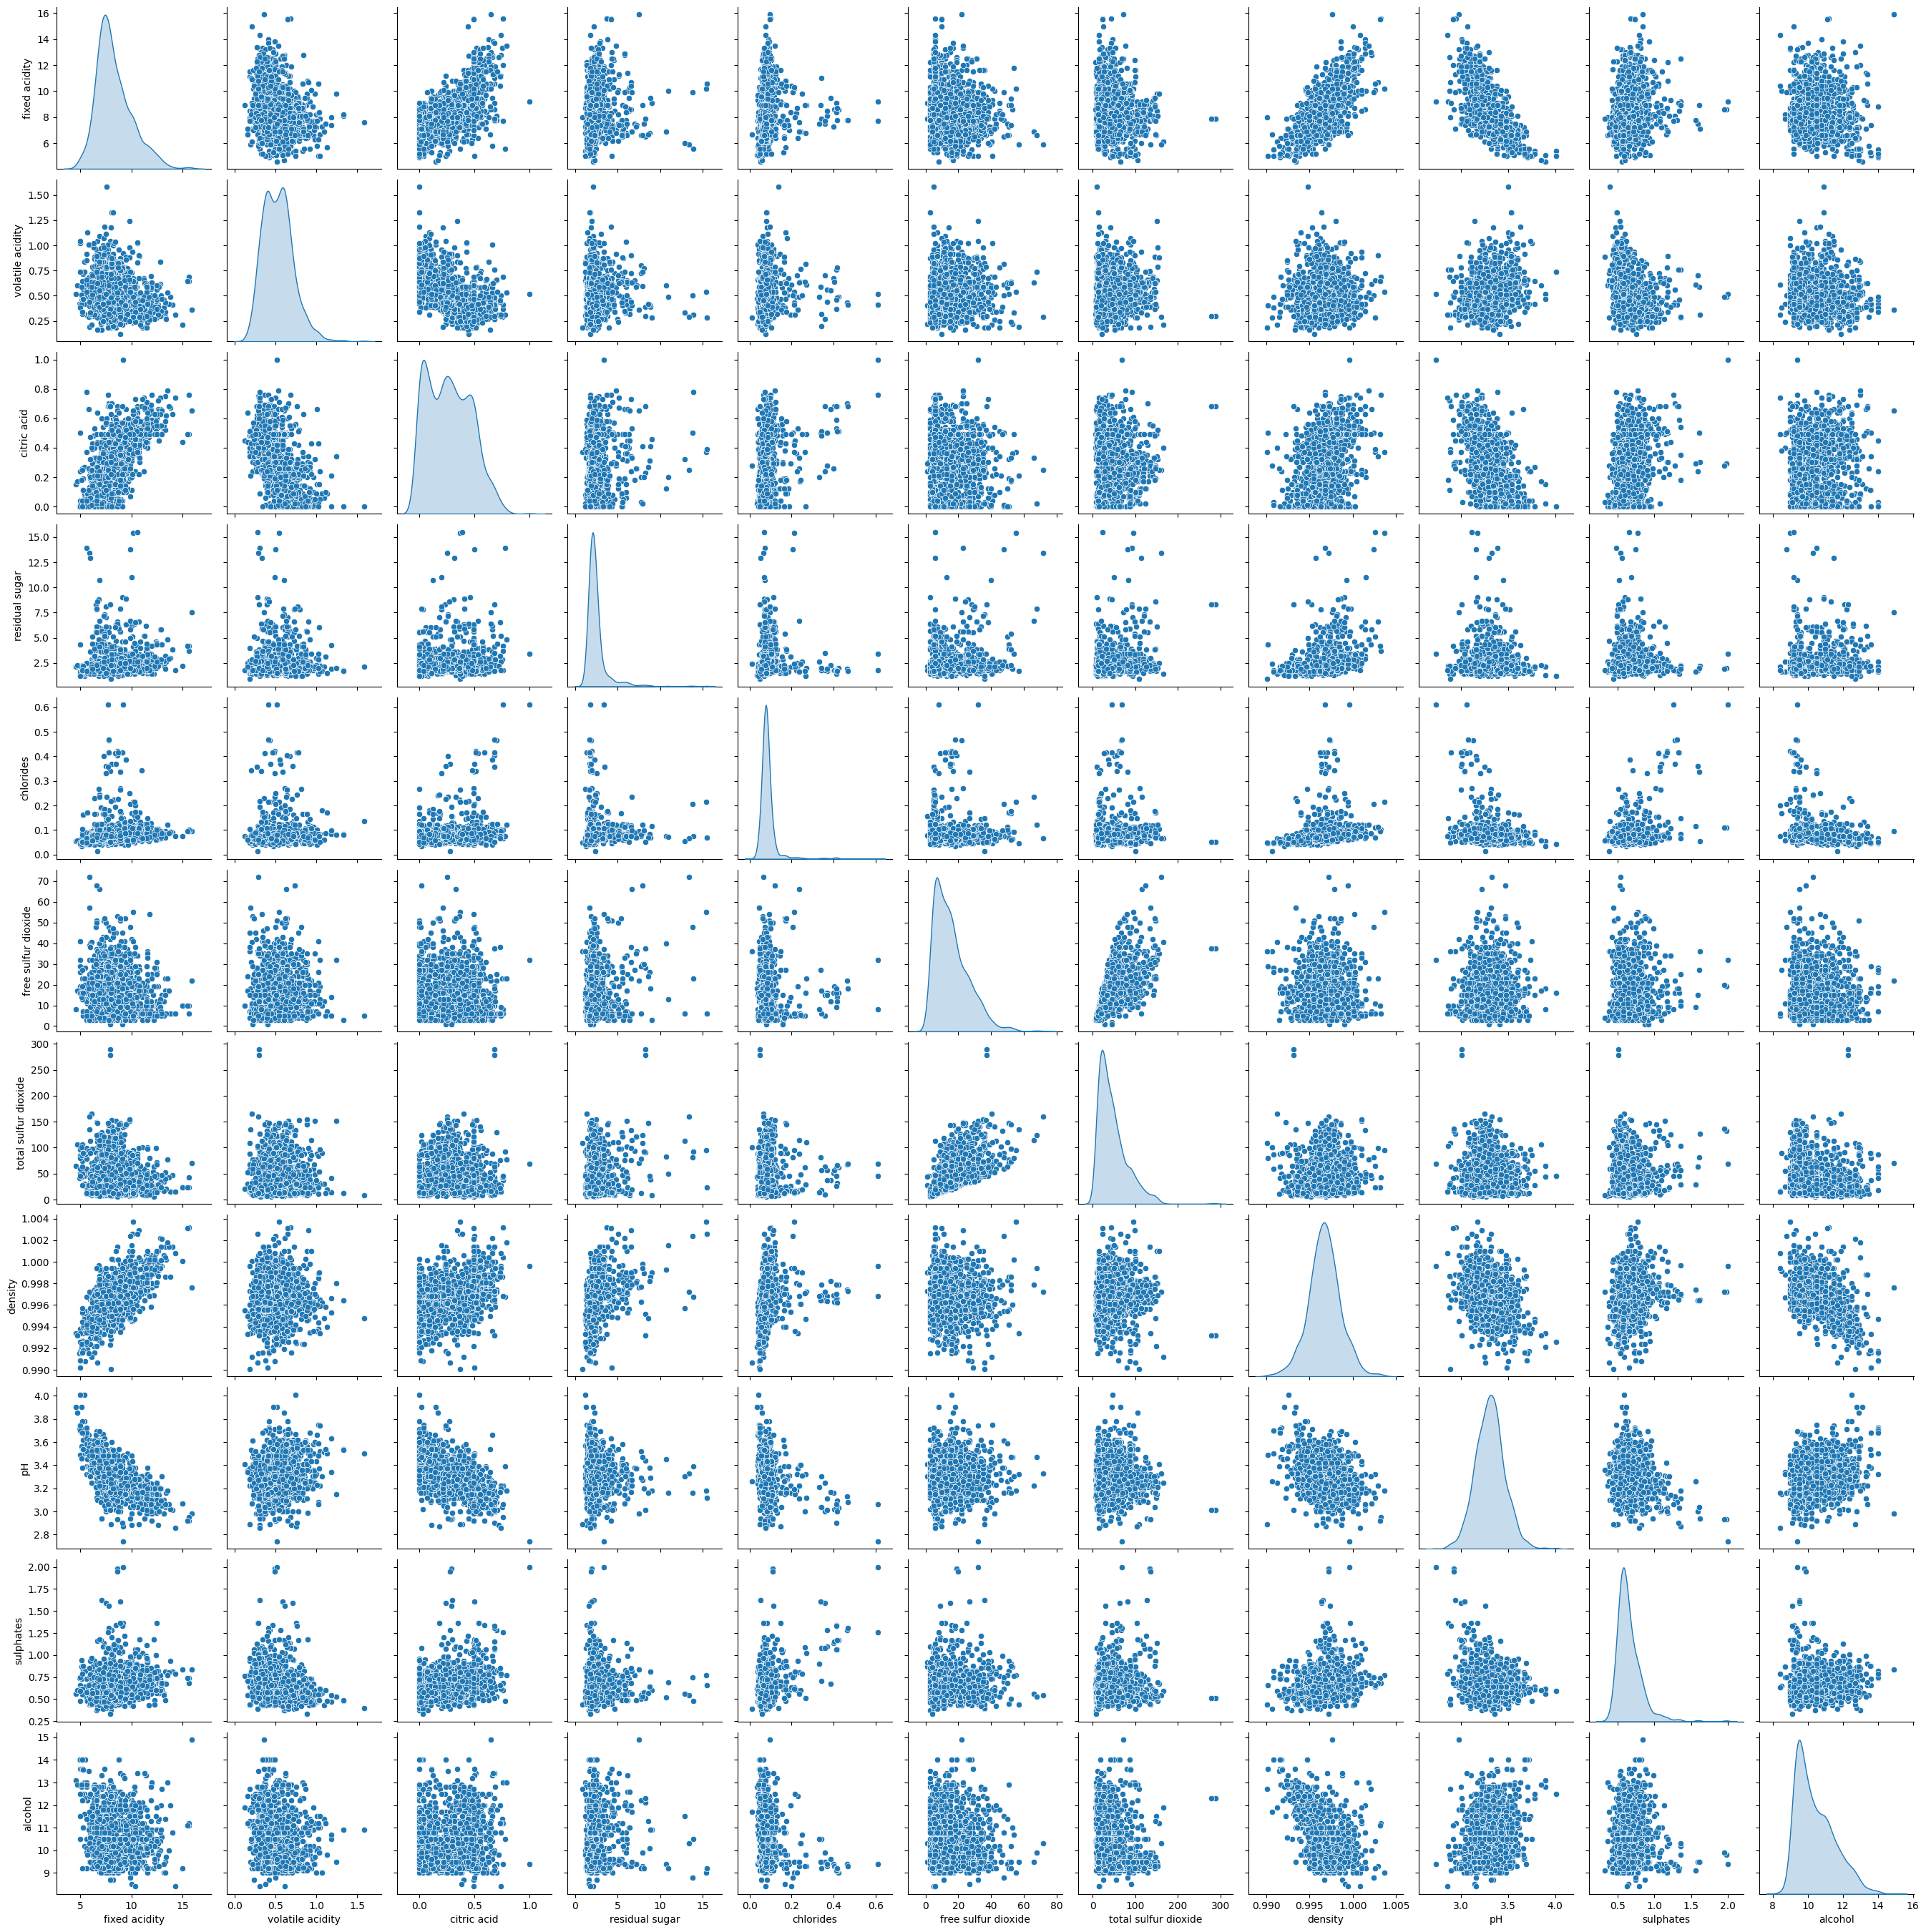

In [21]:
%%time
sns.pairplot(df_s.toPandas().drop('quality', axis=1), diag_kind='kde')
pass;

Распределения переменных отличны от нормальных, практически все имеют правые "хвосты".

In [22]:
# Разделение на обучающую и тестовую выборки
train_df, test_df = df_s.randomSplit([0.7,0.3], seed=20)

In [23]:
train_df.count() 
test_df.count()

940

419

In [24]:
train_df.groupBy('quality').count().show()
test_df.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|      7|  120|
|      8|   12|
|      3|    6|
|      5|  389|
|      6|  379|
|      4|   34|
+-------+-----+

+-------+-----+
|quality|count|
+-------+-----+
|      7|   47|
|      8|    5|
|      3|    4|
|      5|  188|
|      6|  156|
|      4|   19|
+-------+-----+



In [25]:
feature_cols = df_s.columns[:-1]
len(feature_cols)

11

In [26]:
gc.collect()

354171

In [27]:
df_assembler = VectorAssembler(inputCols=feature_cols, 
                               outputCol="features")
vdf_train = df_assembler.transform(train_df)
vdf_test = df_assembler.transform(test_df)

In [28]:
vdf_train.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- features: vector (nullable = true)



In [29]:
vdf_train.select(['features','quality']).show(5, False)

+---------------------------------------------------------+-------+
|features                                                 |quality|
+---------------------------------------------------------+-------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]  |4      |
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9] |6      |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|6      |
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |6      |
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0] |8      |
+---------------------------------------------------------+-------+
only showing top 5 rows



Для масштабирования независимых переменных применим `MinMaxScaler`.

In [30]:
mmscaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features", 
                        outputCol="scaledFeatures")

In [31]:
scaler = mmscaler.fit(vdf_train)
train_scaled = scaler.transform(vdf_train)
test_scaled = scaler.transform(vdf_test)

In [32]:
train_scaled.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



**RandomForestClassifier**

In [33]:
rf = RandomForestClassifier(labelCol="quality", 
                            featuresCol="scaledFeatures", numTrees=20)
model_rf = rf.fit(train_scaled)

predictions_rf = model_rf.transform(test_scaled)

In [34]:
predictions_rf.select("prediction", "probability", "quality").show(5)

+----------+--------------------+-------+
|prediction|         probability|quality|
+----------+--------------------+-------+
|       6.0|[0.0,0.0,0.0,0.00...|      7|
|       6.0|[0.0,0.0,0.0,0.0,...|      7|
|       6.0|[0.0,0.0,0.0,5.0E...|      6|
|       6.0|[0.0,0.0,0.0,0.00...|      6|
|       6.0|[0.0,0.0,0.0,0.00...|      6|
+----------+--------------------+-------+
only showing top 5 rows



In [35]:
predictions_rf.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
evaluator = MulticlassClassificationEvaluator(labelCol='quality', metricName="weightedFMeasure")

   * param for metric name in evaluation (supports `"f1"` (default), `"accuracy"`,
   * `"weightedPrecision"`, `"weightedRecall"`, `"weightedTruePositiveRate"`,
   * `"weightedFalsePositiveRate"`, `"weightedFMeasure"`, `"truePositiveRateByLabel"`,
   * `"falsePositiveRateByLabel"`, `"precisionByLabel"`, `"recallByLabel"`,
   * `"fMeasureByLabel"`, `"logLoss"`, `"hammingLoss"`) 


In [37]:
# f1 - метрика по умолчанию
print("F1 = {}".format(round(evaluator.evaluate(predictions_rf), 4)))

F1 = 0.5669


In [38]:
gc.collect()

471

**Подбор параметров и кросс-валидация RandomForestClassifier**

In [38]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth,[10])
             .addGrid(rf.impurity, ['gini'])
             .addGrid(rf.numTrees, [100, 200])
             .build())

In [39]:
%%time
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)
cv_model = cv.fit(train_scaled)

In [1]:
best_rf_model = cv_model.bestModel

In [ ]:
# Посмотрим на параметры лучшей модели
best_rf_model._java_obj.getMaxDepth()
best_rf_model._java_obj.getImpurity()
best_rf_model._java_obj.getNumTrees()

10

'gini'

200

In [ ]:
rf_best_pred = best_rf_model.transform(test_scaled)
print("F1 = {}".format(round(evaluator.evaluate(rf_best_pred), 4)))

F1 = 0.5836


---

In [60]:
rf = RandomForestClassifier(labelCol="quality", 
                            featuresCol="scaledFeatures", numTrees=500, maxDepth=20)

In [61]:
model_rf = rf.fit(train_scaled)

predictions_rf = model_rf.transform(test_scaled)

In [62]:
evaluator = MulticlassClassificationEvaluator(labelCol='quality', metricName="weightedFMeasure")

In [63]:
# f1 - метрика по умолчанию
print("F1 = {}".format(round(evaluator.evaluate(predictions_rf), 4)))

F1 = 0.5903


**Выводы**

Из __[моделей для мультиклассовой классификации в `pySpark`](https://spark.apache.org/docs/3.0.0-preview/ml-classification-regression.html#gradient-boosted-tree-classifier)__ в работе использовалась `RandomForestClassifier`. `Gradient-boosted trees` доступен только для бинарной классификации. 

Подготовку данных в `pySpark` целесообразно проводить при действительно большом объеме обработки, чтобы получить все преимущества `pySpark`.  